In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    overload dataset
    """
    def __init__ (self, x, y):
        self.x = x
        self.y = y
        self.x = self.x.float()
        self.y = self.y.long()

    def __len__ (self): 
        return(len(self.y))

    def __getitem__ (self, idx):
        return self.x[idx], self.y[idx]

In [3]:
# load the data
data = torch.load('data/brain_cancer_dataset.pt')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class BrainClassifier(nn.Module):
    def __init__(self):
        super(BrainClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 64 * 64
        self.fc = nn.Linear(fc_input_size, 3) # 3 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        # by default CrossEntropyLoss compute the softmax itself.
        # if leaved uncommented somewhy (????) the model does not learn 
        # remeber to put by hand when you do predictions
        # x = F.softmax(x, dim=1)  
        return x


In [6]:
class minst_classifier(nn.Module):
    def __init__(self):
        super(minst_classifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size
        self.flatten_size = 64 * 3 * 3  # Adjusted from 4*4 to 3*3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.flatten_size, 10)  # Adjust accordingly

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

In [7]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in trange(epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
            # Print the loss
            # if i % 10 == 0:
            #     print(f'Epoch {epoch}, Iteration {i}, Loss {loss.item()}')

        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Validation Loss {val_loss / len(val_data)}')

    return train_losses, val_losses

In [8]:
train_loader = DataLoader(data, batch_size=64, shuffle=True)
val_loader = DataLoader(data, batch_size=64, shuffle=False)

In [9]:
# Test with the NIST dataset

# Define the transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts to float32 and scales to [0, 1]
#     transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5 (example values, adjust if needed)
# ])

# Load the dataset
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# # Create data loaders

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model = minst_classifier()


In [10]:
# Example instantiation and training
model = BrainClassifier()

tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=75, lr=0.001)

tend = time.time()
print("Time elapsed: ", tend-tstart)

  0%|                                                                              | 0/75 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/ipasia00/deepenv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
  1%|▉                                                                   | 1/75 [01:08<1:23:57, 68.07s/it]

Epoch 0, Validation Loss 0.5081594241426346


  8%|█████▍                                                              | 6/75 [06:32<1:14:46, 65.02s/it]

Epoch 5, Validation Loss 0.02987368444991397


 15%|█████████▊                                                         | 11/75 [11:56<1:09:02, 64.73s/it]

Epoch 10, Validation Loss 0.015143912450204222


 21%|██████████████▎                                                    | 16/75 [17:19<1:03:40, 64.75s/it]

Epoch 15, Validation Loss 0.008639042250414354


 28%|███████████████████▎                                                 | 21/75 [22:42<58:09, 64.61s/it]

Epoch 20, Validation Loss 0.004983431660985708


 35%|███████████████████████▉                                             | 26/75 [28:07<52:58, 64.87s/it]

Epoch 25, Validation Loss 0.03493103764693784


 41%|████████████████████████████▌                                        | 31/75 [33:29<47:23, 64.63s/it]

Epoch 30, Validation Loss 0.0011071518680424522


 48%|█████████████████████████████████                                    | 36/75 [38:53<42:07, 64.81s/it]

Epoch 35, Validation Loss 0.0022873740397817213


 55%|█████████████████████████████████████▋                               | 41/75 [44:17<36:39, 64.70s/it]

Epoch 40, Validation Loss 2.245629352111617e-05


 61%|██████████████████████████████████████████▎                          | 46/75 [49:41<31:20, 64.85s/it]

Epoch 45, Validation Loss 1.1592788482062133e-05


 68%|██████████████████████████████████████████████▉                      | 51/75 [55:05<25:52, 64.69s/it]

Epoch 50, Validation Loss 6.417743669828724e-06


 75%|██████████████████████████████████████████████████                 | 56/75 [1:00:27<20:24, 64.45s/it]

Epoch 55, Validation Loss 3.5592478295868997e-06


 81%|██████████████████████████████████████████████████████▍            | 61/75 [1:05:51<15:07, 64.82s/it]

Epoch 60, Validation Loss 1.9649610791173973e-06


 88%|██████████████████████████████████████████████████████████▉        | 66/75 [1:11:16<09:43, 64.79s/it]

Epoch 65, Validation Loss 1.0662088618010618e-06


 95%|███████████████████████████████████████████████████████████████▍   | 71/75 [1:16:39<04:18, 64.55s/it]

Epoch 70, Validation Loss 5.701855100481948e-07


100%|███████████████████████████████████████████████████████████████████| 75/75 [1:20:58<00:00, 64.78s/it]

Time elapsed:  4858.435471773148


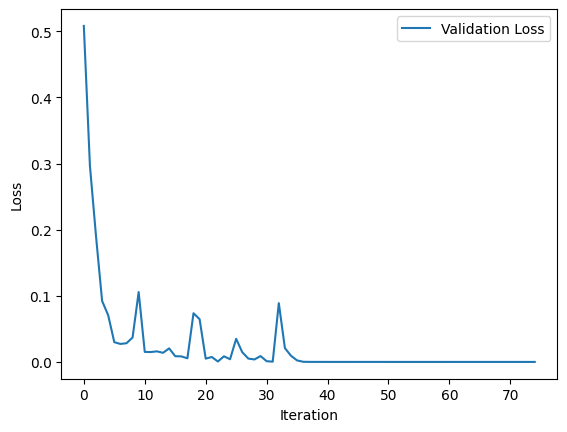

In [18]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
# plt.plot(train_losses, label='Training Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
# plt.xlim((0, 10))
plt.show()

In [12]:
# Save the model weights
torch.save(model.state_dict(), 'brain_classifier_weights.pth')

In [13]:
# check that the model is loadable 
# Initialize the model
model_loaded = BrainClassifier()
# Load the model weights
model_loaded.load_state_dict(torch.load('brain_classifier_weights.pth'))
# Set the model to evaluation mode if you are going to use it for inference
model.eval()

BrainClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=262144, out_features=3, bias=True)
)

In [14]:
x, y = next(iter(train_loader))

In [15]:
model(x.to(device)).argmax(1)

tensor([1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 0], device='cuda:0')

In [16]:
y # vere label

tensor([1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 0])